In [1]:
# You may want to install "gprof2dot"
from collections import Counter
import numpy as np
from numpy import genfromtxt
import scipy.io
import csv
import pandas as pd
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
import sklearn.tree
import matplotlib.pyplot as plt

import random
random.seed(246810)
np.random.seed(246810)

In [16]:
eps = 1e-5  # a small number


# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000


h = np.vectorize(w)

class Node:
    def __init__(self, left=None, right=None, split_rule=None, label=None, leaf=False):
        self.left = left
        self.right = right
        self.split_rule = split_rule
        self.label = label
        self.leaf = leaf
    
    def draw(self, node, level=0):
        current = []
        current.append(node)
        while current:
            lower = []
            for i in current:
                if i.left: 
                    lower.append(i.left)
                if i.right: 
                    lower.append(i.right)
                if i.leaf:
                    print(f"Level:{level} Label:{i.label}")
                else:
                    print(f"Level:{level} Feature Index:{i.split_rule[0]} Thresh:{i.split_rule[1]}")
            level += 1
            current = lower     

class DecisionTree:

    def __init__(self, max_depth=3, feature_labels=None):
        # TODO implement __init__ function
        self.max_depth = max_depth
        self.features = feature_labels
        self.start = None
        
    def majority_checker(self, y):
        if (np.count_nonzero(y) > len(y)-np.count_nonzero(y)):
            return 1
        else:
            return 0

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO implement information gain function
        left_node = y[np.where(X < thresh)]
        right_node = y[np.where(X >= thresh)]
        weighted = (np.dot(len(left_node), DecisionTree.entropy(left_node)) + np.dot(len(right_node), DecisionTree.entropy(right_node))) / len(y)
        return (DecisionTree.entropy(y) - weighted)

    @staticmethod
    def entropy(y):
        # TODO implement entropy (or optionally gini impurity) function
        one = np.count_nonzero(y)
        zero = len(y) - one
        if len(y) == 0 or zero == 0 or one == 0:
            return 0;
        else:
            p_zero = zero / len(y)
            p_one = one / len(y)
            return (-np.dot(p_zero, np.log2(p_zero))-np.dot(p_one, np.log2(p_one)))
    
    def find_best_split(self, X, y):
        idx = 0
        thresh = 0
        max_gain = 0
        best_idx = 0
        best_thresh = 0
        for feature in range(X.shape[1]):
            for thr in np.unique(X[:,feature]):
                current_gain = DecisionTree.information_gain(X[:,feature], y, thr)
                if (current_gain > max_gain):
                    best_idx = feature
                    best_thresh = thr
                    max_gain = current_gain
        return best_idx, best_thresh
        
    def grow_tree(self, X, y, depth=0):
        if DecisionTree.entropy(y) == 0 or depth == self.max_depth:
            majority = self.majority_checker(y)
            return Node(leaf = True, label=majority)
        else:
            idx, thresh = self.find_best_split(X, y)
            left_node_idx = np.where(X[:,idx] < thresh)[0]
            right_node_idx = np.where(X[:,idx] >= thresh)[0]
            depth += 1
            return Node(self.grow_tree(X[left_node_idx], y[left_node_idx], depth), self.grow_tree(X[right_node_idx], y[right_node_idx], depth), split_rule=(idx, thresh))

    def fit(self, X, y):
        # TODO implement fit function
        self.start = self.grow_tree(X, y)
        return self

    def predict(self, X):
        # TODO implement predict function
        prediction = np.ones(X.shape[0])
        for j in range(X.shape[0]):
            temp = X[j,:]
            node = self.start
            while not node.leaf:
                idx, thresh = node.split_rule
                if temp[idx] < thresh:
                    node = node.left
                else:
                    node = node.right
            prediction[j] = np.round(node.label)
        return prediction
        
    def validation(self, prediction, y):
        return np.sum(np.round(prediction) == y)/len(y)
        
        
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, depth=3, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTree(max_depth=depth, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO implement function
        for i in range(self.n):
            bagged_index = np.random.choice(X.shape[0], size = X.shape[0])
            self.decision_trees[i].fit(X[bagged_index, :], y[bagged_index])
            

    def predict(self, X):
        # TODO implement function
        prediction = []
        for i in range(self.n):
            prediction.append(self.decision_trees[i].predict(X))
        result = stats.mode(prediction).mode[0]
        return result
    
    def validation(self, prediction, y):
        return np.sum(prediction == y)/len(y) 

class RandomForest(BaggedTrees):
    def __init__(self, depth=3, params=None, n=200, m=1):
        if params is None:
            params = {}
        # TODO implement function
        self.n = n
        self.m = m
        self.params = params
        self.decision_trees = [
            DecisionTree(max_depth = depth, feature_labels=m, **self.params)
            for i in range(self.n)
        ]
        

# You do not have to implement the following boost part, though it might help with Kaggle.
class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass


def evaluate(clf):
    print("Cross validation:")
    cv_results = cross_validate(clf, X, y, cv=5, return_train_score=True)
    train_results = cv_results['train_score']
    test_results = cv_results['test_score']
    avg_train_accuracy = sum(train_results) / len(train_results)
    avg_test_accuracy = sum(test_results) / len(test_results)

    print('averaged train accuracy:', avg_train_accuracy)
    print('averaged validation accuracy:', avg_test_accuracy)
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)

    return avg_train_accuracy, avg_test_accuracy

In [24]:
if __name__ == "__main__":
    dataset = "spam"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = './datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        spam_random = np.random.permutation(len(X))
        X_shuffle = X[spam_random]
        y_shuffle = y[spam_random]
        number = int(np.dot(0.2, len(X)))
        X_valid = X_shuffle[:number]
        y_valid = y_shuffle[:number]
        X_train = X_shuffle[number:]
        y_train = y_shuffle[number:]
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    
    
    depth_accuracy = []
    for j in range(1, 41):
        dt = DecisionTree(max_depth=j, feature_labels=features)
        dt.fit(X_train, y_train)
        depth_accuracy.append(dt.validation(dt.predict(X_valid), y_valid))
        print("Maximum Depth:", j, "Accuracy", dt.validation(dt.predict(X_valid), y_valid))

Maximum Depth: 1 Accuracy 0.7707930367504836
Maximum Depth: 2 Accuracy 0.7852998065764023
Maximum Depth: 3 Accuracy 0.8056092843326886
Maximum Depth: 4 Accuracy 0.8075435203094777
Maximum Depth: 5 Accuracy 0.8085106382978723
Maximum Depth: 6 Accuracy 0.8210831721470019
Maximum Depth: 7 Accuracy 0.8220502901353965
Maximum Depth: 8 Accuracy 0.8220502901353965
Maximum Depth: 9 Accuracy 0.8268858800773694
Maximum Depth: 10 Accuracy 0.8230174081237911
Maximum Depth: 11 Accuracy 0.8201160541586073
Maximum Depth: 12 Accuracy 0.8307543520309478
Maximum Depth: 13 Accuracy 0.8288201160541586
Maximum Depth: 14 Accuracy 0.8346228239845261
Maximum Depth: 15 Accuracy 0.8307543520309478
Maximum Depth: 16 Accuracy 0.8307543520309478
Maximum Depth: 17 Accuracy 0.8249516441005803
Maximum Depth: 18 Accuracy 0.8249516441005803
Maximum Depth: 19 Accuracy 0.8259187620889749
Maximum Depth: 20 Accuracy 0.8288201160541586
Maximum Depth: 21 Accuracy 0.8278529980657641
Maximum Depth: 22 Accuracy 0.82688588007736

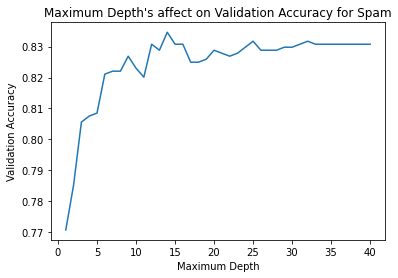

In [25]:
plt.plot(range(1,41), depth_accuracy)
plt.xlabel("Maximum Depth")
plt.ylabel("Validation Accuracy")
plt.title("Maximum Depth's affect on Validation Accuracy for Spam")
plt.show()

In [26]:
maximum = max(depth_accuracy)
max_idx = depth_accuracy.index(maximum)
print("At Maximum Depth:", max_idx, "it has the highest accuracy of", maximum)


At Maximum Depth: 13 it has the highest accuracy of 0.8346228239845261


In [18]:
if __name__ == "__main__":
    dataset = "spam"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = './datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        spam_random = np.random.permutation(len(X))
        X_shuffle = X[spam_random]
        y_shuffle = y[spam_random]
        number = int(np.dot(0.2, len(X)))
        X_valid = X_shuffle[:number]
        y_valid = y_shuffle[:number]
        X_train = X_shuffle[number:]
        y_train = y_shuffle[number:]
        class_names = ["Ham", "Spam"]
    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)   
        
    
    
    
    print('==================================================')
    print("\n\nSimplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X_train, y_train)
    print("Training Accuracy", dt.validation(dt.predict(X_train), y_train))
    print("Validation Accuracy", dt.validation(dt.predict(X_valid), y_valid))


    print('==================================================')
    print("\n\nRandom Forest")
    random_forest = RandomForest(depth=4, n=100, m=np.sqrt(X.shape[1]))
    random_forest.fit(X_train, y_train)
    print("Training Accuracy", random_forest.validation(random_forest.predict(X_train), y_train))
    print("Validation Accuracy", random_forest.validation(random_forest.predict(X_valid), y_valid))



Simplified decision tree
Training Accuracy 0.7979700338327694
Validation Accuracy 0.7872340425531915


Random Forest
Training Accuracy 0.8013533107781537
Validation Accuracy 0.7882011605415861


In [19]:
dt.start.draw(dt.start)

Level:0 Feature Index:28 Thresh:1.0
Level:1 Feature Index:19 Thresh:1.0
Level:1 Feature Index:31 Thresh:1.0
Level:2 Feature Index:29 Thresh:1.0
Level:2 Label:0
Level:2 Feature Index:19 Thresh:1.0
Level:2 Feature Index:7 Thresh:1.0
Level:3 Label:0
Level:3 Label:0
Level:3 Label:1
Level:3 Label:0
Level:3 Label:0
Level:3 Label:1


In [20]:
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(name + 'submission.csv', index_label='Id')
    
random_forest = RandomForest(depth=4, n=100, m=np.sqrt(X.shape[1]))
random_forest.fit(X_train, y_train)
results_to_csv(random_forest.predict(Z), "spam")


In [21]:
from sklearn.impute import SimpleImputer
import collections
import random

if __name__ == "__main__":
    dataset = "titanic"
    params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data       
        path_train = 'datasets/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        titanic_y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]
        
        
        titanic_raw = pd.read_csv(path_train)
        

        titanic_raw.drop(['ticket', 'cabin'], inplace=True, axis=1)
        
        sex = titanic_raw['sex']
        embarked = titanic_raw['embarked']
        
        label_encoder = sklearn.preprocessing.LabelEncoder()
        sex_integer_encoded = label_encoder.fit_transform(sex)
        titanic_raw.drop(['sex'], inplace=True, axis=1)
        titanic_raw.insert(2, 'sex', sex_integer_encoded)
        
        embarked_label_encoder = sklearn.preprocessing.LabelEncoder()
        embarked_onehot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
        embarked_integer_encoded = embarked_label_encoder.fit_transform(embarked)
        embarked_integer_encoded = embarked_integer_encoded.reshape(len(embarked_integer_encoded), 1)
        embarked_onehot_encoded = embarked_onehot_encoder.fit_transform(embarked_integer_encoded)
        
        titanic_raw.drop(['embarked'], inplace=True, axis=1)
        new_embarked = []
        for i in embarked_onehot_encoded:
            new_embarked.append(i[:-1].tolist())
        
        
        imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
        imputer = imputer.fit(titanic_raw)
        titanic_raw = imputer.transform(titanic_raw)
        titanic_label = titanic_raw[:,:1]
        titanic_raw = titanic_raw[:,1:]
        titanic_raw = titanic_raw.tolist()
        
        for i in range(len(titanic_raw)):
            titanic_raw[i].extend(new_embarked[i])                  
        
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        titanic_test = pd.read_csv(path_test)
        
        titanic_test.drop(['ticket', 'cabin'], inplace=True, axis=1)
        sex_test = titanic_test['sex']
        embarked_test = titanic_test['embarked']
        
        test_label_encoder = sklearn.preprocessing.LabelEncoder()
        test_sex_integer_encoded = test_label_encoder.fit_transform(sex_test)
        titanic_test.drop(['sex'], inplace=True, axis=1)
        titanic_test.insert(1, 'sex', test_sex_integer_encoded)
        
        test_embarked_label_encoder = sklearn.preprocessing.LabelEncoder()
        test_embarked_onehot_encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)
        test_embarked_integer_encoded = test_embarked_label_encoder.fit_transform(embarked_test)
        test_embarked_integer_encoded = test_embarked_integer_encoded.reshape(len(test_embarked_integer_encoded), 1)
        test_embarked_onehot_encoded = test_embarked_onehot_encoder.fit_transform(test_embarked_integer_encoded)
        test_embarked_onehot_encoded = test_embarked_onehot_encoded.tolist()
        titanic_test.drop(['embarked'], inplace=True, axis=1)
        
        imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
        imputer = imputer.fit(titanic_test)
        titanic_test = imputer.transform(titanic_test)
        titanic_test = titanic_test.tolist()
        
                
        for i in range(len(titanic_test)):
            titanic_test[i].extend(test_embarked_onehot_encoded[i])
            
        titanic_test = np.array(titanic_test)
                    
        shuffle = list(zip(titanic_raw, titanic_label))
        random.shuffle(shuffle)
        titanic_X_shuffle = []
        titanic_y_shuffle = []
        for i in range(len(shuffle)):
            titanic_X_shuffle.append(shuffle[i][0])
            titanic_y_shuffle.append(shuffle[i][1])
        titanic_X_valid = titanic_X_shuffle[:200]
        titanic_y_valid = titanic_y_shuffle[:200]
        titanic_X_train = titanic_X_shuffle[200:]
        titanic_y_train = titanic_y_shuffle[200:]
        titanic_X_valid = np.array(titanic_X_valid)
        titanic_y_valid = np.array(titanic_y_valid)
        titanic_X_train = np.array(titanic_X_train)
        titanic_y_train = np.array(titanic_y_train)
        
        final_y_train = []
        for i in titanic_y_train:
            final_y_train.extend(i)
        final_y_valid = []
        for i in titanic_y_valid:
            final_y_valid.extend(i)
        
  
                
    print('==================================================')
    print("\n\nSimplified decision tree")
    dt = DecisionTree(max_depth=4, feature_labels=features)
    dt.fit(titanic_X_train, titanic_y_train)
    print("Training Accuracy", dt.validation(dt.predict(titanic_X_train), final_y_train))
    print("Validation Accuracy", dt.validation(dt.predict(titanic_X_valid), final_y_valid))
    
    print('==================================================')
    print("\n\nRandom Forest")
    random_forest = RandomForest(depth=4, n=100, m=np.sqrt(X.shape[1]))
    random_forest.fit(titanic_X_train, titanic_y_train)
    print("Training Accuracy", random_forest.validation(random_forest.predict(titanic_X_train), final_y_train))
    print("Validation Accuracy", random_forest.validation(random_forest.predict(titanic_X_valid), final_y_valid))
        

/var/folders/q4/7jwgy08937ld9tb9kfkptn9h0000gp/T/ipykernel_24665/702764023.py:17: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
/var/folders/q4/7jwgy08937ld9tb9kfkptn9h0000gp/T/ipykernel_24665/702764023.py:58: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)




Simplified decision tree
Training Accuracy 0.8260325406758448
Validation Accuracy 0.74


Random Forest
Training Accuracy 0.8247809762202754
Validation Accuracy 0.825


In [22]:
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(name + 'submission.csv', index_label='Id')
    
dt = DecisionTree(max_depth=4, feature_labels=features)
dt.fit(titanic_X_train, titanic_y_train)
results_to_csv(dt.predict(titanic_test), "titanic")

In [23]:
dt = DecisionTree(max_depth=3, feature_labels=features)
dt.fit(titanic_X_train, titanic_y_train)
dt.start.draw(dt.start)

Level:0 Feature Index:1 Thresh:1.0
Level:1 Feature Index:0 Thresh:3.0
Level:1 Feature Index:0 Thresh:2.0
Level:2 Feature Index:5 Thresh:26.25
Level:2 Feature Index:5 Thresh:23.45
Level:2 Feature Index:2 Thresh:55.0
Level:2 Feature Index:2 Thresh:10.0
Level:3 Label:1
Level:3 Label:1
Level:3 Label:1
Level:3 Label:0
Level:3 Label:0
Level:3 Label:0
Level:3 Label:0
Level:3 Label:0
